In [1]:
"""
Portfolio Project: Feature Engineering & Statistical Analysis for Financial Data

This script performs data loading, feature engineering, winsorization,
correlation analysis, and statistical testing to identify feature importance.
"""

# Libraries
from collections import Counter
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats import shapiro, mannwhitneyu

# The following imports are not used in this script but may be used later in modeling.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (mean_squared_error, r2_score, 
                             classification_report, confusion_matrix, accuracy_score,
                             roc_curve, auc)

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

In [2]:
def load_data(filepath: str) -> pd.DataFrame:
    """
    Load the CSV data file.
    """
    try:
        df = pd.read_csv(filepath)
        logging.info("Data loaded successfully.")
        return df
    except FileNotFoundError as e:
        logging.error(f"File not found: {filepath}")
        raise e

In [3]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform feature engineering:
      - Fill missing values,
      - Create financial ratios and metrics,
      - Convert date fields and create target dates.
    """
    # Fill missing totalCurrentLiabilities using totalLiabilities
    df['totalCurrentLiabilities'] = df['totalCurrentLiabilities'].fillna(df['totalLiabilities'])
    
    # Compute totalEquity and additional ratios
    df['totalEquity'] = df['totalLiabilitiesAndTotalEquity'] - df['totalLiabilities']
    df['currentRatio'] = df['totalCurrentAssets'] / df['totalCurrentLiabilities']
    df['debtToEquity'] = df['totalDebt'] / df['totalEquity']
    df['ROE'] = df['netIncome_x'] / df['totalEquity']
    df['inventoryTurnover'] = df['costOfRevenue'] / df['inventory_x']
    df['Return'] = df.groupby('symbol_stock')['Adj Close'].pct_change()
    df['ROA'] = df['netIncome_x'] / df['totalAssets']
    df['free_cash_flow_yield'] = df['freeCashFlow'] / df['totalEquity']
    df['Profit_Margin'] = df['netIncome_x'] / df['revenue']
    df['Op_Cash_Flow_to_Revenue'] = df['operatingCashFlow'] / df['revenue']
    
    if 'dividendsPaid' in df.columns and 'netIncome_x' in df.columns:
        df['retained_earnings'] = df['netIncome_x'] - df['dividendsPaid']
        df['re_ratio'] = df['retained_earnings'] / df['netIncome_x']
    
    df['capital_light'] = df['capitalExpenditure'] / df['operatingCashFlow']
    
    # Additional sector-level metrics
    df['goodwillIntangible_to_assets'] = df['goodwillAndIntangibleAssets'] / df['totalAssets']
    df['sellingMarketing_to_revenue'] = df['sellingAndMarketingExpenses'] / df['revenue']
    df['totalInvestments_to_assets'] = df['totalInvestments'] / df['totalAssets']
    df['rnd_to_revenue'] = df['researchAndDevelopmentExpenses'] / df['revenue']
    df['inventory_to_assets'] = df['inventory_x'] / df['totalAssets']
    
    # Date conversion & target date calculation
    df['accepted_date'] = pd.to_datetime(df['acceptedDate_x'])
    horizon_days = 365 * 5  # 5-year return horizon
    df['target_date'] = df['accepted_date'] + pd.Timedelta(days=horizon_days)
    
    # Sort data by stock symbol and date for later operations
    df = df.sort_values(by=['symbol_stock', 'accepted_date'])
    
    return df

In [4]:
def merge_future_prices(df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge future price information into the main DataFrame using merge_asof.
    """
    # Create a separate prices DataFrame 
    df_prices = df[['symbol_stock', 'accepted_date', 'Adj Close']].rename(
        columns={'accepted_date': 'future_date', 'Adj Close': 'future_price'}
    ).sort_values('future_date')
    
    # Ensure no missing dates
    logging.info(f"Missing accepted_date: {df['accepted_date'].isnull().sum()}")
    logging.info(f"Missing target_date: {df['target_date'].isnull().sum()}")
    
    df = df.dropna(subset=['accepted_date'])
    df['target_date'] = df['accepted_date'] + pd.Timedelta(days=365 * 5)
    df_prices = df_prices.dropna(subset=['future_date'])
    
    df_model = pd.merge_asof(
        left=df.sort_values('target_date'),
        right=df_prices,
        left_on='target_date',
        right_on='future_date',
        by='symbol_stock',
        direction='forward'
    )
    
    # Calculate future return and remove rows without available future price
    df_model['Return_future'] = (df_model['future_price'] - df_model['Adj Close']) / df_model['Adj Close']
    df_model = df_model.dropna(subset=['Return_future']).copy()
    
    # Create binary target: 1 if future return > (specified number)%, else 0
    df_model['good_stock'] = (df_model['Return_future'] > 0.25).astype(int)
    
    # Replace inf values and drop rows with missing key features
    # Dropping nan because don't feel comfortable with imputing with mean or median
    # Good chance company might not have debt or assets, etc. 
    # Results in only dropping a few thousand rows out of ~155k rows.
    df_model.replace([np.inf, -np.inf], np.nan, inplace=True)
    cols_required = ['ROE', 'ROA', 'free_cash_flow_yield', 'debtToEquity', 'eps', 'epsdiluted',
                     're_ratio', 'Op_Cash_Flow_to_Revenue', 'ebitda', 'ebitdaratio',
                     'goodwillIntangible_to_assets', 'sellingMarketing_to_revenue',
                     'totalInvestments_to_assets', 'rnd_to_revenue', 'inventory_to_assets',
                     'Profit_Margin']
    df_model = df_model.dropna(subset=cols_required)
    
    logging.info(f"Data shape after merge and cleaning: {df_model.shape}")
    return df_model

In [5]:
def winsorize_column(df: pd.DataFrame, col: str, limits: list) -> pd.Series:
    """
    Winsorize a column and print summary statistics.
    
    Parameters:
        df      : Input DataFrame.
        col     : Column name to winsorize.
        limits  : Winsorization limits (e.g., [0.01, 0.01]).
        
    Returns:
        winsorized version of the column (as a pd.Series).
    """
    original_mean = df[col].mean()
    winsorized = winsorize(df[col], limits=limits)
    winsorized_mean = winsorized.mean()
    print(f"{col}: original mean = {original_mean:.4f}, winsorized mean = {winsorized_mean:.4f}")
    print(f"{col} range: {df[col].min()} to {df[col].max()}")
    print(f"{col} winsorized range: {winsorized.min()} to {winsorized.max()}\n")
    return winsorized

In [6]:
def apply_winsorization(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply winsorization to a set of features and add the winsorized columns
    to the DataFrame with a '_win' suffix.
    """
    # Mapping of columns to their winsorization limits
    # Stating features; using the winsorized versions of most features and focusing on mostly
    # ratios to capture context and not let raw $$ metrics overwhelm
    winsor_limits = {
        'Profit_Margin': [0.01, 0.01],
        'inventory_to_assets': [0.01, 0.01],
        'rnd_to_revenue': [0.01, 0.01],
        'totalInvestments_to_assets': [0.01, 0.01],
        'goodwillIntangible_to_assets': [0.01, 0.01],
        'sellingMarketing_to_revenue': [0.01, 0.01],
        'ebitda': [0.01, 0.01],
        'ebitdaratio': [0.01, 0.01],
        'ROE': [0.01, 0.01],
        'ROA': [0.01, 0.01],
        'free_cash_flow_yield': [0.01, 0.01],
        'debtToEquity': [0.01, 0.01],
        're_ratio': [0.05, 0.05],
        'eps': [0.05, 0.05],
        'epsdiluted': [0.05, 0.05],
        'Op_Cash_Flow_to_Revenue': [0.05, 0.05],
    }
    
    # Apply winsorization for each feature in the dictionary
    for col, limits in winsor_limits.items():
        new_col = col + '_win'
        df[new_col] = winsorize_column(df, col, limits)
    
    return df

In [7]:
def correlation_analysis(df: pd.DataFrame, features: list, target: str) -> None:
    """
    Compute and print the correlation matrix (Pearson and Spearman) for the provided features.
    """
    # Pearson correlation with target (and with future return
    corr_matrix = df[features + [target, 'Return_future']].corr()
    print("Pearson Correlation Matrix:\n", corr_matrix, "\n")
    
    # Spearman correlation -- better for non-linear relationships
    spearman_corr = df[features + [target]].corr(method='spearman')
    print("Spearman Correlation Matrix:\n", spearman_corr, "\n")
    
    # Spearman correlation for target, sorted by absolute correlation
    spearman_target = spearman_corr[target].drop(target)
    spearman_top_features = spearman_target.abs().sort_values(ascending=False)
    print("Spearman Rank Correlation for target (good_stock):\n", spearman_top_features, "\n")

In [8]:
def sector_analysis(df: pd.DataFrame, features: list, ignore_cols: list, top_n_per_sector: int = 20) -> pd.DataFrame:
    """
    Analyze Spearman correlations by Sector and aggregate the top features (votes) across sectors.
    
    Returns a DataFrame of aggregated vote counts.
    """
    sectors = df['Sector'].unique()
    sector_spearman = {}
    
    for sector in sectors:
        print(f"Processing sector: {sector}")
        df_sector = df[df['Sector'] == sector].copy()
        # Select only numeric columns excluding ignored ones; ensure target is included.
        df_sector_numeric = df_sector.select_dtypes(include=['number']).drop(columns=ignore_cols, errors='ignore')
        df_sector_numeric['good_stock'] = df_sector['good_stock']
        # Compute Spearman correlation for all numeric features with target
        spearman_corr = df_sector_numeric.corr(method='spearman')['good_stock'].drop('good_stock')
        top_spearman = spearman_corr.abs().sort_values(ascending=False).head(top_n_per_sector)
        sector_spearman[sector] = top_spearman
        print("Top Spearman correlations:")
        print(top_spearman)
        print("-" * 50)
    
    # Aggregate votes across sectors
    all_votes = []
    for top_feats in sector_spearman.values():
        all_votes.extend(top_feats.index.tolist())
    
    vote_counts = Counter(all_votes)
    vote_counts_df = pd.DataFrame.from_dict(vote_counts, orient='index', columns=['Votes'])
    vote_counts_df = vote_counts_df.sort_values(by='Votes', ascending=False)
    
    print("Aggregated Spearman vote counts:")
    print(vote_counts_df, "\n")
    
    # Plot the top 20 vote counts
    top_20_votes = vote_counts_df.head(20)
    top_20_votes.plot(kind='bar', title='Top 20 Aggregated Spearman Vote Counts', legend=False)
    plt.ylabel('Votes')
    plt.tight_layout()
    plt.show()
    
    return vote_counts_df

In [9]:
def perform_statistical_tests(df: pd.DataFrame, features: list) -> None:
    """
    Conduct Shapiro-Wilk tests for normality and Mann-Whitney U tests comparing
    the distributions of each feature between good and bad stocks.
    """
    print("Shapiro-Wilk Normality Test Results:")
    for feature in features:
        data = df[feature].dropna()
        stat, p = shapiro(data)
        print(f"{feature}: p-value = {p:.4f}")
        if p < 0.05:
            print(f"  - {feature} likely deviates from normality.\n")
        else:
            print(f"  - {feature} likely is normally distributed.\n")
    
    # Since the features are not normally distributed, we will run a Mann-Whitney U test for 
    # features differences by good_stock, as opposed to a t-test which assumes normality.
    print("\nMann-Whitney U Test Results (Good vs. Bad Stocks):")
    for feature in features:
        group_good = df[df['good_stock'] == 1][feature].dropna()
        group_bad = df[df['good_stock'] == 0][feature].dropna()
        stat, p = mannwhitneyu(group_good, group_bad, alternative='two-sided')
        print(f"{feature}: U-statistic = {stat:.2f}, p-value = {p:.4f}")
    
    # Statistical tests by Sector
    if 'Sector' in df.columns:
        print("\nMann-Whitney U Test by Sector:")
        for sector in df['Sector'].unique():
            print(f"\nSector: {sector}")
            df_sector = df[df['Sector'] == sector]
            for feature in features:
                group_good = df_sector[df_sector['good_stock'] == 1][feature].dropna()
                group_bad = df_sector[df_sector['good_stock'] == 0][feature].dropna()
                if len(group_good) > 0 and len(group_bad) > 0:
                    stat, p = mannwhitneyu(group_good, group_bad, alternative='two-sided')
                    print(f"  {feature}: U-statistic = {stat:.2f}, p-value = {p:.4f}")
                else:
                    print(f"  {feature}: Insufficient data in one or both groups.")

In [10]:
def main():
    # Load and preprocess data
    filepath = 'combined.00-25.csv'
    df = load_data(filepath)
    df = feature_engineering(df)
    df_model = merge_future_prices(df)
    
    # Apply winsorization on selected features
    df_model = apply_winsorization(df_model)
    
    # Define features 
    features = [
        'ROE_win', 'ROA_win', 'free_cash_flow_yield_win', 'debtToEquity_win', 're_ratio_win',
        'eps_win', 'epsdiluted_win', 'ebitda_win', 'ebitdaratio_win',
        'goodwillIntangible_to_assets_win', 'sellingMarketing_to_revenue_win',
        'totalInvestments_to_assets_win', 'rnd_to_revenue_win', 'inventory_to_assets_win',
        'Profit_Margin_win'
    ]

    target = 'good_stock'
    
    # Perform correlation analysis
    correlation_analysis(df_model, features, target)
    
    # Define columns to ignore for sector analysis
    ignore_cols = [
        'good_stock', 'calendarYear', 'calendarYear_y', 'calendarYear_x', 
        'Adj Close', 'quarter_number', 'future_price', 
        'cik_x', 'cik_y', 'cik', 'Unnamed: 0.1', 'Unnamed: 0',
        'Return_future'
    ]
    vote_counts_df = sector_analysis(df_model, features, ignore_cols, top_n_per_sector=20)
    
    # Perform statistical tests
    perform_statistical_tests(df_model, features)

    return df_model

In [11]:
# if __name__ == "__main__":
#     main()

Performing winsorization on most, if not all, of the features. I went through the dataset and looked at the extreme values. Most are legitimate, but are wild outliers so they are capped. The high or low values are maintained but the magnitude is lessened. Since most of the features are ratios, -80,000% isn't reasonable.

The winsorized columns are better correlated with returns/good_stock as well.

Correlation numbers are still low. This is common in financial analysis because features have non-linear relationships with the target. Also, it takes more than just one or a handful of features to determine a company's health. In this case, the flow of cash, return on assets, equity and earnings seem to be relatively important. This seems very reasonable.

## Takeaways
Consumer Defensive 
- Established, stable companies: weightedAverageShsOut and weightedAverageShsOutDil serve as proxies 
- Ability to generate steady cash: FreeCashFlow and free_cash_flow_yield
- Manage liabilities well: CapitalLeaseObligations and shortTermDebt (don't have a ratio here, perhaps should make one)

Technology
- Growth & Investment: StockBasedCompensation and commonStockRepurchased might indicate management confidence, but also increase when returns grow, so too much collinearity here. Idea for possibly creating a lag or rolling growth metric.
- Cash Flow: invest in R&D, infrastructure, new software, etc. Example: Apple has a huge cash flow, and is universally considered healthy for it. Can withstand hardships.
- Size: WeightedAverageShsOut stand out
- Volatile stocks, so cash flow, investment, and growth will be important here

Healthcare
- Earnings: EPS and related stats are high, profitability is important 
- R&D: very reasonable; need to be efficient in the R&D spending; need to create new breakthroughs but efficiently 
- Again size: with weightedAverageShsOut and weightedAverageShsOutDil being highly important 

Financial Services
- Debt management: proper leverage is vital, very reasonable to see debt_win and debtToEquity high 
- Profitability: with the leverage, important to turn a profit, because they aren't as reliant on R&D or infrastructure investment for that future pay-off
- Other Balance Sheet: taxAssets, PreferredStock show capital structure

Industrials
- Operational efficiency: GrossProfit, freeCashFlow, operatingCashFlow, and operatingIncome; think factories and assembly line - efficient 
- Size: economies of scale seem important here; if can scale horizontally, huge benefit
- Operational cash flow

Consumer Cyclical
- Performance when economy is doing well: EPS and related
- Volatile: Noticeably lower values compared to other sectors; dependent on economy moreso than other factors
- Size: have to imagine consumers go to well-known brands if they have to purchase from a trend-dependent industry
- Capital efficiency: that said, company should be efficient and manage inventory well

Energy
- Liquidity: InterestIncome, cashAndCashEquivalents, and cashAndShortTermInvestments
- Leverage & Expense management: InterestExpense, goodwill, and other expense-related metrics
- Earnings and returns: roe_win
- Liquidity and efficient capital allocation important since the sector is so capital-driven

Basic Materials
- Liquidity: CashAtBeginningOfPeriod, cashAndShortTermInvestments to support operations
- Reinvest in production: CapitalExpenditure, investmentsInPropertyPlantAndEquipment, and totalInvestments_to_assets
- Operational efficiency: InventoryTurnover

Real Estate
- Balance Sheet strength: AccountPayables, totalLiabilities, and netDebt are critical to assessing leverage
- Asset management: TotalAssets and totalCurrentAssets help understand the overall scale and efficiency of the asset base
- Cash flow: CashAtBeginning/EndOfPeriod and dividendsPaid give insight into liquidity and income generation
- Strong balance sheet and efficient use of assets: high leverage in this Sector

Communication Services
- Size: WeightedAverageShsOutDil and weightedAverageShsOut; perhaps large companies are dominant because of the upfront costs
- Expense management: TaxPayables and researchAndDevelopmentExpenses, and rnd_to_revenue_win show the balance needed between investment in new tehc/infrastructure and operational costs
- Cash flow: need the cash flow to continue never-ending reinvestment
- Cost management: Driven by scale and efficient investment in network or content

Utilities
- Expense control: SellingGeneralAndAdministrativeExpenses and generalAndAdministrativeExpenses highlight cost management
- Liquidity: ShortTermInvestments, cashAndShortTermInvestments, and cashAndCashEquivalents indicate a strong liquidity position, important for dividend-paying, regulated utilities
- Divident and Return measures: DividendsPaid and retainedEarnings
- Stability and consistent cash flow: liquidity and steady operational costs important

INFO: Data loaded successfully.
INFO: Missing accepted_date: 17
INFO: Missing target_date: 17
/var/folders/qt/m1d2k3qd4_z368vlhrz0r7w80000gn/T/ipykernel_31578/1949378372.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target_date'] = df['accepted_date'] + pd.Timedelta(days=365 * 5)
INFO: Data shape after merge and cleaning: (154722, 159)


Profit_Margin: original mean = -86.5023, winsorized mean = -0.1128
Profit_Margin range: -12.815603376530733 to 1.4815177437804399
Profit_Margin winsorized range: -12.815603376530733 to 1.4815177437804399

inventory_to_assets: original mean = 2.7219, winsorized mean = 0.0793
inventory_to_assets range: -0.032017201489100124 to 0.5672233318344854
inventory_to_assets winsorized range: -0.032017201489100124 to 0.5672233318344854

rnd_to_revenue: original mean = 57.0048, winsorized mean = 0.0931
rnd_to_revenue range: -0.0 to 4.295006570302234
rnd_to_revenue winsorized range: -0.0 to 4.295006570302234

totalInvestments_to_assets: original mean = 174.8118, winsorized mean = 0.1433
totalInvestments_to_assets range: -0.10085953650310087 to 0.9954933312932704
totalInvestments_to_assets winsorized range: -0.10085953650310087 to 0.9954933312932704

goodwillIntangible_to_assets: original mean = 1.1568, winsorized mean = 0.1463
goodwillIntangible_to_assets range: -0.017708296635546943 to 0.7478991596

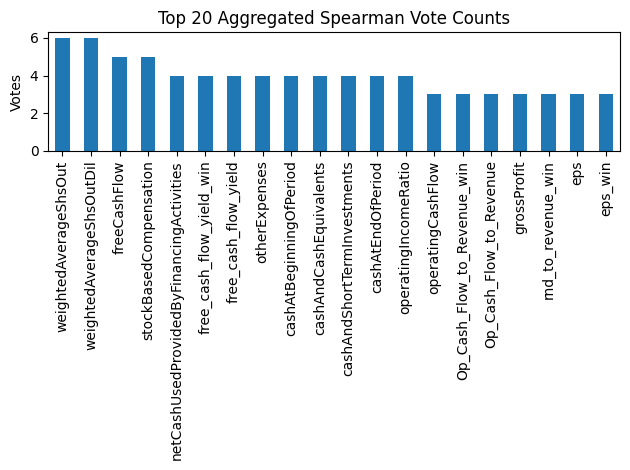

Shapiro-Wilk Normality Test Results:
ROE_win: p-value = 0.0000
  - ROE_win likely deviates from normality.

ROA_win: p-value = 0.0000
  - ROA_win likely deviates from normality.

free_cash_flow_yield_win: p-value = 0.0000
  - free_cash_flow_yield_win likely deviates from normality.

debtToEquity_win: p-value = 0.0000
  - debtToEquity_win likely deviates from normality.

re_ratio_win: p-value = 0.0000
  - re_ratio_win likely deviates from normality.

eps_win: p-value = 0.0000
  - eps_win likely deviates from normality.

epsdiluted_win: p-value = 0.0000
  - epsdiluted_win likely deviates from normality.

ebitda_win: p-value = 0.0000
  - ebitda_win likely deviates from normality.

ebitdaratio_win: p-value = 0.0000
  - ebitdaratio_win likely deviates from normality.

goodwillIntangible_to_assets_win: p-value = 0.0000
  - goodwillIntangible_to_assets_win likely deviates from normality.

sellingMarketing_to_revenue_win: p-value = 0.0000
  - sellingMarketing_to_revenue_win likely deviates fro

/Users/arshsingh/Documents/Montclair/portfolio-masters-capstone/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 154722.
  res = hypotest_fun_out(*samples, **kwds)


ROE_win: U-statistic = 2959499842.50, p-value = 0.0000
ROA_win: U-statistic = 3032873407.50, p-value = 0.0000
free_cash_flow_yield_win: U-statistic = 3057670889.50, p-value = 0.0000
debtToEquity_win: U-statistic = 2884756708.50, p-value = 0.0000
re_ratio_win: U-statistic = 2938041844.00, p-value = 0.0000
eps_win: U-statistic = 2779043707.00, p-value = 0.0000
epsdiluted_win: U-statistic = 2780615934.00, p-value = 0.0000
ebitda_win: U-statistic = 2987776103.00, p-value = 0.0000
ebitdaratio_win: U-statistic = 2862748612.00, p-value = 0.0000
goodwillIntangible_to_assets_win: U-statistic = 2921717453.00, p-value = 0.0000
sellingMarketing_to_revenue_win: U-statistic = 2789554664.50, p-value = 0.0000
totalInvestments_to_assets_win: U-statistic = 2702576373.00, p-value = 0.0000
rnd_to_revenue_win: U-statistic = 2767139406.00, p-value = 0.0000
inventory_to_assets_win: U-statistic = 2916772798.00, p-value = 0.0000
Profit_Margin_win: U-statistic = 2866225440.00, p-value = 0.0000

Mann-Whitney U T

,Unnamed: 0.1,Unnamed: 0,date,symbol_fin,reportedCurrency_x,cik_x,fillingDate_x,acceptedDate_x,calendarYear_x,period_x,...,ebitda_win,ebitdaratio_win,ROE_win,ROA_win,free_cash_flow_yield_win,debtToEquity_win,re_ratio_win,eps_win,epsdiluted_win,Op_Cash_Flow_to_Revenue_win
0,169987,200306,2000-01-01,PPC,USD,802481.0,2000-01-21,2000-01-21 00:00:00,1999,Q4,...,3.390000e+07,0.094983,0.048158,0.022818,0.056238,0.540724,1.040268,0.36,0.36,0.089628
1,184759,219375,2000-01-01,SANM,USD,897723.0,2000-01-27,2000-01-27 00:00:00,2000,Q1,...,1.023000e+08,0.150968,0.054297,0.027870,-0.090295,0.532773,1.000000,0.96,0.90,-0.074396
2,124136,147385,2000-01-31,LFCR,USD,1005286.0,2000-01-31,2000-01-30 19:00:00,2000,Q3,...,-1.300000e+06,-0.041420,-0.052023,-0.022444,-0.109827,0.514451,0.903992,-0.18,-0.18,0.038462
3,30539,37646,2000-01-31,BMO,CAD,927971.0,2000-01-31,2000-01-30 19:00:00,2000,Q1,...,3.052951e+09,1.459336,0.042197,0.002074,-0.337344,0.417371,1.320818,0.84,0.84,-0.527154
4,183467,217821,2000-01-31,RY,CAD,0.0,2000-01-31,2000-01-30 19:00:00,2000,Q1,...,0.000000e+00,1.242615,0.041714,0.001952,-0.233314,0.401429,1.343398,0.41,0.40,-0.527154


In [12]:
final_df = main()
final_df.head()

In [14]:
# desired_columns = [
#     'symbol_stock', 'Sector', 'quarter_number', 'acceptedDate_x', 'roe_win', 'roa_win', 'fcf_win', 
#     'debt_win', 're_win', 'eps_win', 'epsdiluted_win', 'ebitda', 'ebitdaratio', 
#     'goodwillIntangible_to_assets_win', 'sellingMarketing_to_revenue_win', 
#     'totalInvestments_to_assets_win', 'rnd_to_revenue_win', 
#     'inventory_to_assets_win', 'Profit_Margin_win', 'good_stock', 'Return_future'
# ]

# final_df[desired_columns]
# final_df.to_csv('tableau.csv')